# Part 1: Intro, and the all-important import statements

## Rename this file.
You may do so by clicking on the filename to the right of the Jupyter logo at the top. Replace \[lastname\] with your last name or surname and \[firstname] with your first name or given name.

## Read this.
By reading near-surface data from the NASA MERRA2 reanalysis product from May 31, 2021, we can create a four panel plot showing:

* the pressure of the bottom model level (near the surface)
* the modeled sea level pressure
* the calculated sea level pressure (constant $\overline{T}$)
* the calculated sea level pressure (constant $\overline\Gamma=6.5$ K km$^{-1}$)

This will also give you good practice with the approximate solutions to the hydrostatic approximation given in §4.2.

## Run the cell below.

In [1]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from metpy.plots import add_metpy_logo
from metpy.units import units
import latexify
import warnings
warnings.filterwarnings('ignore')

crs = ccrs.Robinson()

# Function used to create the map subplots
def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    return ax

# Part 2: Calculating SLP based on $p_s$ and $T_s$
## Read this.
A challenge with this assignment is that we are accustomed to thinking of equations like §4.33,
$$p(z)=p_0-\rho g z$$
as representing the pressure $p$ for some positive altitude $z$ above sea level (where $z=0$ and $p=0$).

For this assignment, instead of thinking of sea level as $z_0=0$, try to think of the ground as $z_0=0$. But what does that make $z$ for sea level? Well, if the ground is *above* sea level by some amount, that means sea level is *below* ground by that same amount, right? So $z$ will be the surface altitude multiplied by negative 1.

Also, since $z_0=0$ corresponds to the ground, then so does $p_0$; that is, $p_0$ represents the surface pressure. What, then, is $p(z)$? It's the sea level pressure!

That may be a little tricky. Try sketching it out if it's wracking your brain. __This is the biggest conceptual leap needed for this assignment.__

## Practice by testing this function that calculates $p(z)$ from $p_S$ and $z$ based on constant density $\rho$.*
*We're also assuming constant gravity $g$, if you recall. See §4.1.2.

We're not going to plot sea level pressure maps based on the constant-density assumption. But we will use this function later on in this lab to practice. Also, this gives you an example to follow when you fix the other functions and use them later.

In [ ]:
"""
Like the functions in the week 5 lab, these functions are going to assume you're working in SI base units,
i.e. pascals, meters, etc., rather than hectopascals or kilomters.
"""
@latexify.function
def calc_p_constant_rho(p_0, z, g, rho):
    # I'll calculate this one for you. 
    return p_0-rho*g*z
calc_p_constant_rho

In [ ]:
a = 101300 # 1013 hPa, but in SI units of Pa
b = 1300 # approximate altitude of Salt Lake City is 1300 meters
c = 9.8 # good value for g is 9.8 ms^-1
d = 1.25 # typical value for ρ is 1.25 kg m -3 according to Petty (on the bottom of page 94)
print(f"If p_0={a}, z={b}, g={c}, and ρ={c}, then p(z)={calc_p_constant_rho(a, b, c, d)}.")

## Consider the following.
If you left $a$, $b$, $c$, and $d$ alone, you should have gotten $p(z)\approx 854$ hPa. A typical surface pressure for Salt Lake City is 875 hPa. If you were asked to, could you explain why the pressure decreased more quickly with height under the constant density assumption than it does for the real atmosphere?
## Fix and test a function to calculate $p(z)$ from $p_S$ and $z$ based on constant temperature $T$.

In [4]:
@latexify.function
def calc_p_constant_T(p_0, z, R_d, T, g):
    # I'll calculate scale-height for you so you can use it in your expression on the return line
    H = R_d * T / g

    # I'm defining e here so you don't have to learn numpy
    e = np.exp(1)

    # This line is intentionally bad, but notice how it uses e and H? Also, ** means exponentiation.
    return p_0*e**(0.0*H)
calc_p_constant_T

In [ ]:
a = 101300 # 1013 hPa, but in SI units of Pa
b = 1300 # approximate altitude of Salt Lake City is 1300 meters
c = 300 # a reasonable surface temperature
d = 273.13 # freezing temperature
e = 9.8 # good value for g is 9.8 ms^-1
print(f"If p_0={a}, z={b}, R_d={c}, T={d}, and g={e}, then p(z)={calc_p_constant_T(a, b, c, d, e)}.")

## Consider the following.
If you left $a$, $b$, $c$, $d$, and $e$ alone, you should have gotten $p(z)\approx 867$ hPa. That's closer to 875 hPa. Could you explain to someone why this is more accurate?

## Fix and test a function to calculate $p(z)$ from $p_S$ and $z$ based on constant lapse rate $\Gamma$.

In [6]:
@latexify.function
def calc_p_constant_Gamma(p_0, z, R_d, T_0, g, Gamma):
    # I'll calculate T(z) for you so you can use it in the return line
    T = T_0-Gamma*z

    # This line is intentionally bad, but notice how it uses T?
    return p_0*T**0.0
calc_p_constant_Gamma

In [ ]:
a = 101300 # 1013 hPa, but in SI units of Pa
b = 1300 # approximate altitude of Salt Lake City is 1300 meters
c = 300 # a reasonable surface temperature
d = 273.13 # freezing temperature
e = 9.8 # good value for g is 9.8 ms^-1
f = 0.0065 # remember to use SI units, or K/m, not K/km.
print(f"If p_0={a}, z={b}, R_d={c}, T_0={d}, g={e}, and Γ={f}, then p(z)={calc_p_constant_Gamma(a, b, c, d, e, f)}.")

## Consider the following.
If you left $a$, $b$, $c$, $d$, $e$, and $f$ alone, you should have gotten $p(z)\approx 865$ hPa. That's *further* from 875 hPa than we got with the constant temperature assumption. There's a straightforward reason why this is. Could you explain why?

# Part 3: Apply your calculations to real data.
## Read this.
We're going to be using real data *with units*. If your code above is good, things should be dimensionally consistent, and things should just work. "Hold on to your hats!"

## Run the cell below to define constants *with units*.

In [8]:
gravity = 9.80665*units.meters/units.seconds/units.seconds
Rd = 287.047*units.joules/units.kg/units.kelvin
gamma = 0.0065*units.kelvin/units.meter
density = 1.25*units.kg/units.meter/units.meter/units.meter

## Run the cell below to read in data from the NASA [MERRA2 Reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/merra-2/).
A reanalysis uses a forecast model and observations to do something like a zero-hour forecast (or analysis) for every hour retrospectively. If you want to analyze a past weather event, a reanalysis is a great place to start.
You can download data yourself [here](https://disc.gsfc.nasa.gov/datasets?project=MERRA-2) if you're interested.

These data are distributed as [netCDF](https://www.unidata.ucar.edu/software/netcdf/) files, which are the [Unidata](https://www.unidata.ucar.edu/) standard file format for gridded data. I told you that GRIB2s are stacked maps. netCDFs can be many-dimensional. So if you just want weather maps, GRIB2s are great. If you want anything else, netCDFs are more flexible. I prefer netCDFs, but that's probably reflecting my bias as a scientist rather than an operational forecaster.

In [9]:
# Open the example netCDF data
with xr.open_dataset('MERRA2.tavg3.20210531.bottom_level_for_week_6.nc4') as ds:
    
    # Combine 1D latitude and longitudes into a 2D grid of locations
    lon_2d, lat_2d = np.meshgrid(ds['lon'], ds['lat'])
    
    # Pull out the 0000–0300Z average and 1200–1500Z average data
    # THESE ARE THE 0130 AND 1330 VARIABLES THAT GRAD STUDENTS WILL USE
    ml_z_0130 = ds['H'][0][0]*units.meters # middle-of-layer height in meters
    ml_p_0130 = ds['PL'][0][0]*units.pascals # middle-of-layer pressure in pascals
    slp_0130 = ds['SLP'][0]*units.pascals # sea level pressure from model output
    ml_t_0130 = ds['T'][0][0]*units.kelvins # middle-of-layer temperature in Kelvins
    ml_z_1330 = ds['H'][1][0]*units.meters # middle-of-layer height in meters
    ml_p_1330 = ds['PL'][1][0]*units.pascals # middle-of-layer pressure in pascals
    slp_1330 = ds['SLP'][1]*units.pascals # sea level pressure from model output
    ml_t_1330 = ds['T'][1][0]*units.kelvins # middle-of-layer temperature in Kelvins
    
# calculate a daily average from 12-hours-apart values
# THIS IS THE MODELED SLP THAT YOU WILL PLOT
slp_avg = ((slp_0130 + slp_1330.data) / 2.) # sea level pressure from model output

# THESE ARE THE VARIABLES YOU WILL USE FOR YOUR CALCULATIONS
ml_z_avg = ((ml_z_0130 + ml_z_1330.data) / 2.) # middle-of-bottommost-layer height in meters
ml_p_avg = ((ml_p_0130 + ml_p_1330.data) / 2.) # middle-of-bottommost-layer pressure in pascals
ml_t_avg = ((ml_t_0130 + ml_t_1330.data) / 2.) # middle-of-bottomoost-layer temperature in Kelvins

## Carefully examine and run the next cell of code.
* For $g$, I used the variable `gravity`, which is defined a few cells up, and includes units.
* For $\rho$, I used the variable `density`, which is defined along with `gravity`, and also includes units.

Remember that __biggest conceptual link__ I mentioned above? Now is where it becomes important.
* For $p_0$, I used `ml_p_avg`, the pressure at the middle of the model level closest to the surface.
* For $z$, I used `-ml_z_avg`, the altitude of the middle of the model level closest to the surface, *multiplied by negative one!* This is important for the reasons I described at the beginning of this lab.

In [10]:
# make sure the pressure is in Pascals for calculations
ml_p_avg = ml_p_avg.metpy.convert_units('Pa')

# remember     "def calc_p_constant_rho(     p_0,         z,       g,     rho):"
slp_const_rho_avg = calc_p_constant_rho(ml_p_avg, -ml_z_avg, gravity, density)

## Check the output from the constant-density SLP calculator.

In [ ]:
slc_row = 261
slc_col = 109
print(f'Salt Lake City (SLC) @ approx {lat_2d[slc_row, slc_col]}°N, {-lon_2d[slc_row, slc_col]}°W')
print(f'p_0 near SLC: {ml_p_avg[slc_row, slc_col].data}')
print(f'altitude near SLC: {ml_z_avg[slc_row, slc_col].data}')
print(f'SLP (modeled) near SLC: {slp_avg[slc_row, slc_col].data}')
print(f'SLP (constant rho) near SLC: {slp_const_rho_avg[slc_row, slc_col].data}')
# row and column indices corresponding to the gridpoint closest to Salt Lake City

## Consider the following.
If everything went well, the previous cell should have printed out something like this
```
Salt Lake City (SLC) @ approx 40.5°N, 111.875°W
p_0 near SLC: 82036.9375 pascal
altitude near SLC: 1809.669921875 meter
SLP (modeled) near SLC: 101204.1875 pascal
SLP (constant rho) near SLC: 104220.4375 pascal
```
Notice, there are units now! Sweet! How does the altitude here compare to the altitude we used for Salt Lake City earlier? How does $p_0$ here compare to the estimated values for Salt Lake City we calculated earlier? And why is the SLP calculation based on constant-rho unrealistically large?

## Fix and run cells below to calculate SLP two more times.

In [12]:
# make sure the pressure is in Pascals for calculations
ml_p_avg = ml_p_avg.metpy.convert_units('Pa')

"""
Fix the intentionally bad line below. You will use your function defined earlier.
The line will look something like 
slp_const_temp_avg = calc_p_constant_T(   ,  ,    ,  ,  )
But you will need to figure out what to feed the function.
Remember        "def calc_p_constant_T(p_0, z, R_d, T, g):"
You will need the following variables and constants defined (with units) a few cells above:
gravity, Rd, ml_z_avg, ml_p_avg, ml_t_avg
Look to the density calculation above for an example.
"""
slp_const_temp_avg = slp_avg *0.9 # This is intentionally bad.

In [13]:
# make sure the pressure is in Pascals for calculations
ml_p_avg = ml_p_avg.metpy.convert_units('Pa')

"""
Fix the intentionally bad line below. You will use your function defined earlier.
The line will look something like 
slp_const_temp_avg = calc_p_constant_Gamma(   ,  ,    ,    ,  ,      )
But you will need to figure out what to feed the function.
Remember        "def calc_p_constant_Gamma(p_0, z, R_d, T_0, g, Gamma):"
You will need the following variables and constants defined (with units) a few cells above:
gravity, Rd, gamma, ml_z_avg, ml_p_avg, ml_t_avg
Look to the density calculation above for an example.
"""
slp_const_gamma_avg = slp_avg * 1.1 # This is intentionally bad.

## Take a look at the maps below before completing this next step.
The bottom two maps below should look wrong when you first open this lab. This is because I purposefully broke the sea level pressure calculation functions. But still, familiarize yourself with the variables that are shown in these graphs. Notice the limits in the colorbars for each figure. Try to guess what the graphs will look like now that you have (hopefully) fixed the SLP calculators.

## Did you do that? Great! Now run the cell below to re-plot the maps below.
Take a look and see if your results make sense. We'll talk about them in class.

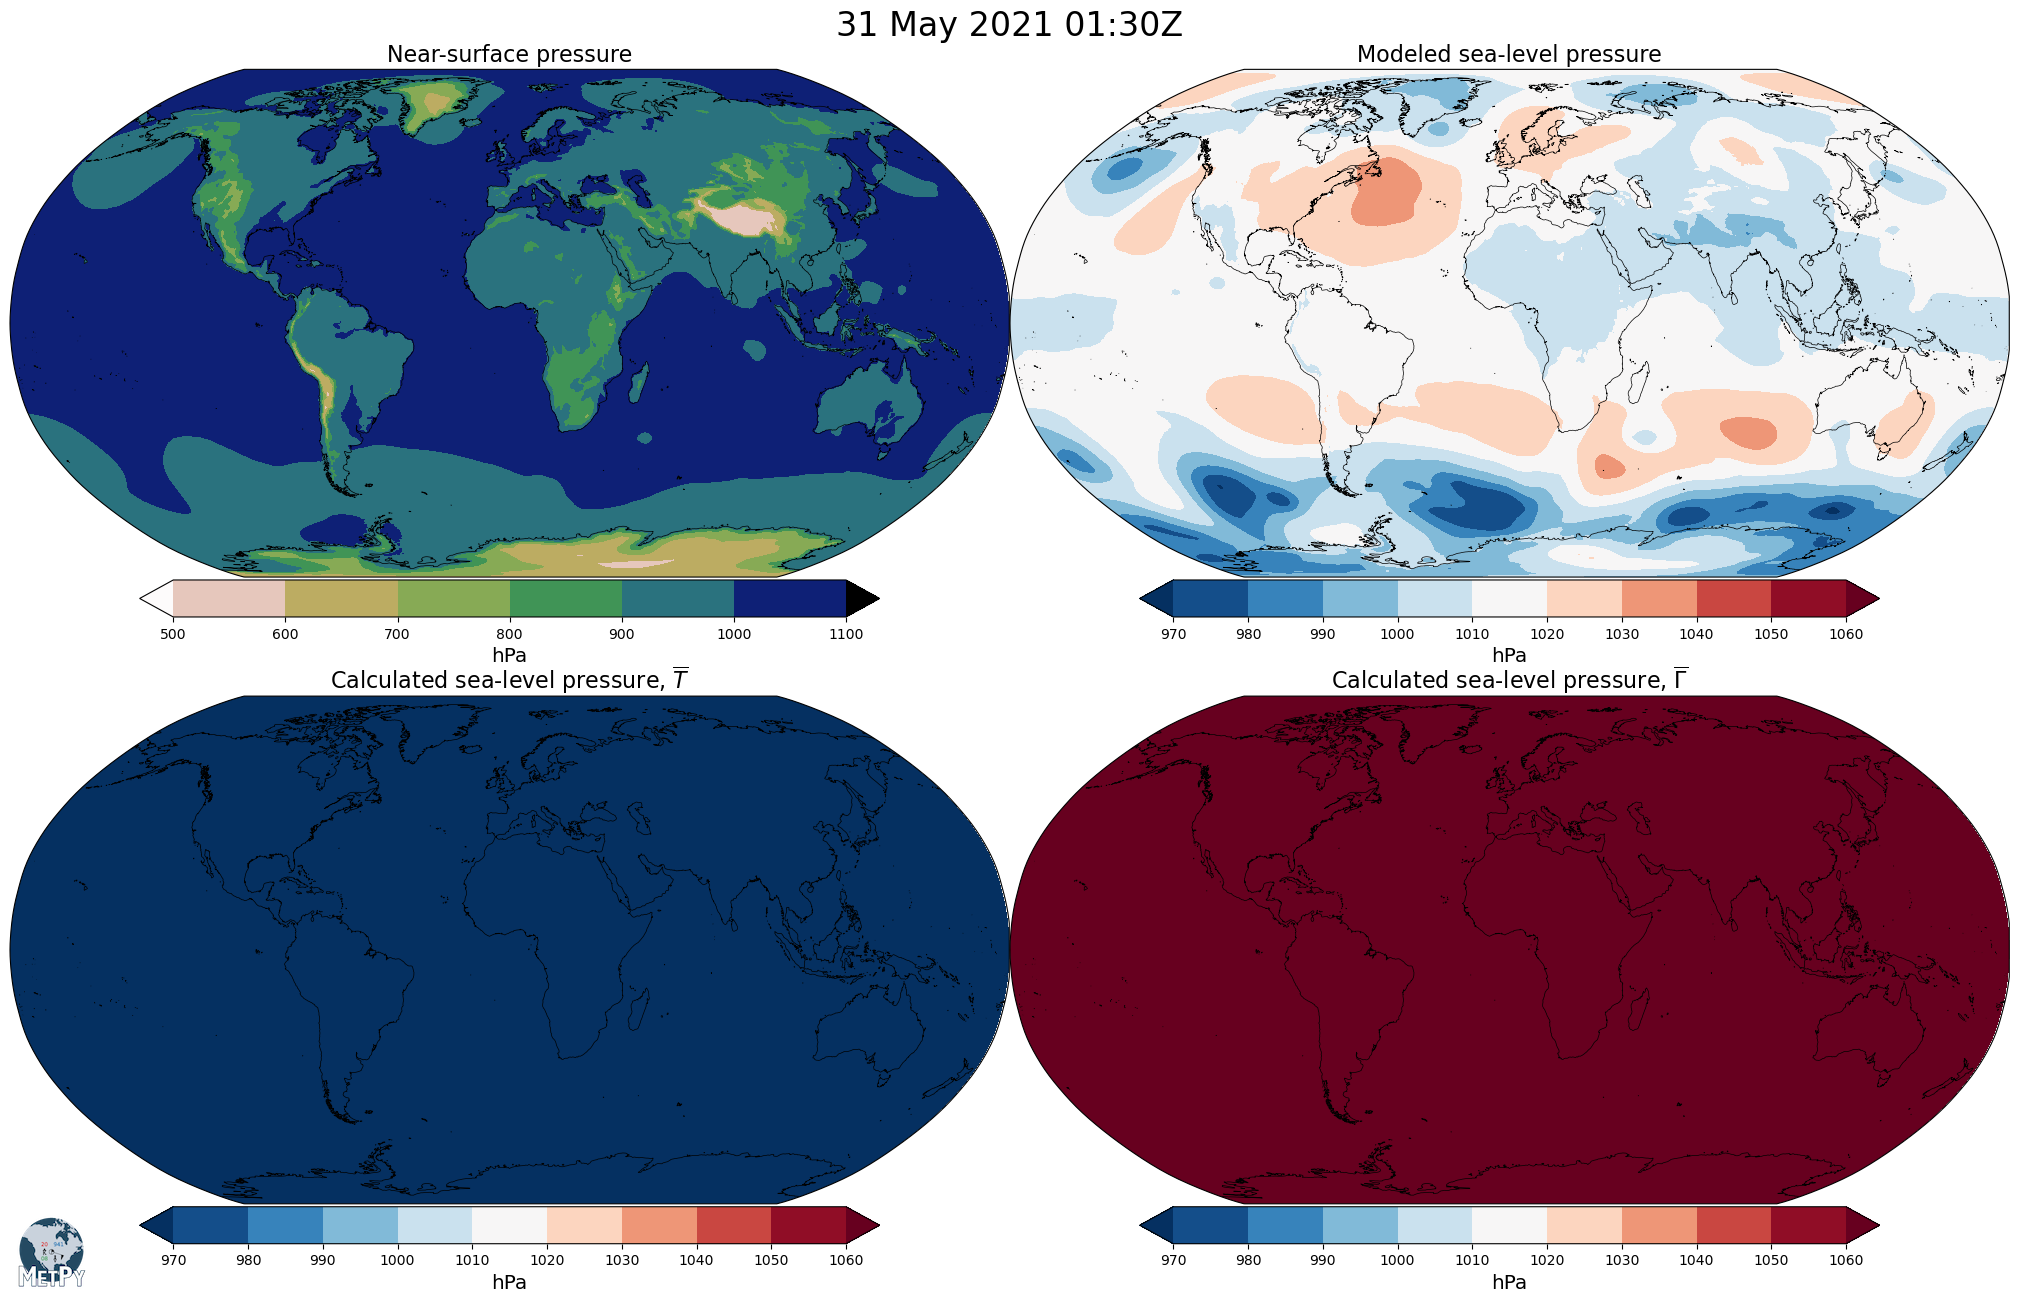

In [14]:
crs = ccrs.Robinson()

# Convert to hPa for plotting
ml_p_avg = ml_p_avg.metpy.convert_units('hPa')
slp_avg = slp_avg.metpy.convert_units('hPa')
slp_const_temp_avg = slp_const_temp_avg.metpy.convert_units('hPa')
slp_const_gamma_avg = slp_const_gamma_avg.metpy.convert_units('hPa')

# Create the figure and plot background on different axes
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 13), constrained_layout=True,
                          subplot_kw={'projection': crs})
add_metpy_logo(fig, 14, 12, size='small')
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

ps_levs = [500, 600, 700, 800, 900, 1000, 1100]
slp_levs = [970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060]
# Upper left plot - near-surface pressure
cf1 = axlist[0].contourf(lon_2d, lat_2d, ml_p_avg, cmap='gist_earth_r', transform=ccrs.PlateCarree(), levels=ps_levs, extend='both', zorder=0)
axlist[0].set_title('Near-surface pressure', fontsize=16) 
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='horizontal', shrink=0.74, pad=0)
cb1.set_label('hPa', size='x-large')

# Upper right plot - modeled sea level pressure
cf2 = axlist[1].contourf(lon_2d, lat_2d, slp_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both', zorder=0)
axlist[1].set_title('Modeled sea-level pressure', fontsize=16)
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='horizontal', shrink=0.74, pad=0)
cb2.set_label('hPa', size='x-large')

# Lower left plot - calculated sea level pressure, constant temperature
cf3 = axlist[2].contourf(lon_2d, lat_2d, slp_const_temp_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both', zorder=0)
axlist[2].set_title(r'Calculated sea-level pressure, $\overline{T}$', fontsize=16) 
cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='horizontal', shrink=0.74, pad=0)
cb3.set_label('hPa', size='x-large')

# Lower right plot - calculated sea level pressure, constant lapse rate
cf4 = axlist[3].contourf(lon_2d, lat_2d, slp_const_gamma_avg, cmap='RdBu_r', transform=ccrs.PlateCarree(), levels=slp_levs, extend='both', zorder=0)
axlist[3].set_title(r'Calculated sea-level pressure, $\overline{\Gamma}$', fontsize=16)
cb4 = fig.colorbar(cf4, ax=axlist[3], orientation='horizontal', shrink=0.74, pad=0)
cb4.set_label('hPa', size='x-large')

# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Set figure title
fig.suptitle(ds['time'][0].dt.strftime('%d %B %Y %H:%MZ').values, fontsize=24)

# Display the plot
plt.show()

# Part 4: Grads only
The calculations done above were for a daily mean, for reasons discussed by Petty. Once you have your calculations above working (and you've tested them with the plots so that you're sure they look good), repeat the steps above for the 0130Z and 1330Z data, subtract the 0130Z data from the 1330Z data, and _plot the difference_. Create a new Markdown cell (I think the default cell type is "Code", but you can change it to "Markdown" using the pulldown menu) and describe your observations in it. What are the major differences between the 0130Z and 1330Z plots? What do you think is the most likely explanation for those differences?

_Hint:_ 0130 is not nighttime everywhere, and 1330 is not daytime everywhere.

_Another Hint:_ Watch your units as you work. Be sure you are working in Pascals for your calculations and plotting in hPa.

# Part 5: Everybody!
## Turn this in!
Go to the "File" menu just below the Jupyter logo, choose "Save and Export Notebook As", and then "HTML".
That should create an HTML file that contains everything you see in this notebook.
Download that HTML file, open it in a browser to make sure it looks good, and submit it to Canvas for your assignment.